In [ ]:
# Install Pycocotools
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Install detectron 2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397874 sha256=7ccc2296bc8b09630227d2beb39d26bdacada05a489c0c25f15ce5678f8a77bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ff0nachi/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-u3l2m_jy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-u3l2m_jy
  Resolved https://github.com/f

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance

In [ ]:
dataDir='/content/drive/MyDrive/car_damage_data/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "/content/drive/MyDrive/car_damage_data/img"

In [ ]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=2.20s)
creating index...
index created!
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu118 True


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
!python -m detectron2.utils.collect_env

-------------------------------  ----------------------------------------------------------------
sys.platform                     linux
Python                           3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
numpy                            1.22.4
detectron2                       0.6 @/usr/local/lib/python3.9/dist-packages/detectron2
Compiler                         GCC 9.4
CUDA compiler                    CUDA 11.8
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.0.0+cu118 @/usr/local/lib/python3.9/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            Tesla T4 (arch=7.5)
Driver version                   525.85.12
CUDA_HOME                        /usr/local/cuda
Pillow                           8.4.0
torchvision                      0.15.1+cu118 @/usr/local/lib/python3.9/dist-packages/torchvision
t

In [ ]:
dataset_dir = "/content/drive/MyDrive/car_damage_data"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [ ]:
#get configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/DetectronPreTrained/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg['MODEL']['DEVICE']='cuda'#or cpu
damage_predictor = DefaultPredictor(cfg)

[04/19 08:59:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DetectronPreTrained/damage_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [ ]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/DetectronPreTrained/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg_mul['MODEL']['DEVICE']='cuda' #or cpu
part_predictor = DefaultPredictor(cfg_mul)

[04/19 08:59:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DetectronPreTrained/part_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [ ]:
def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [ ]:
damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

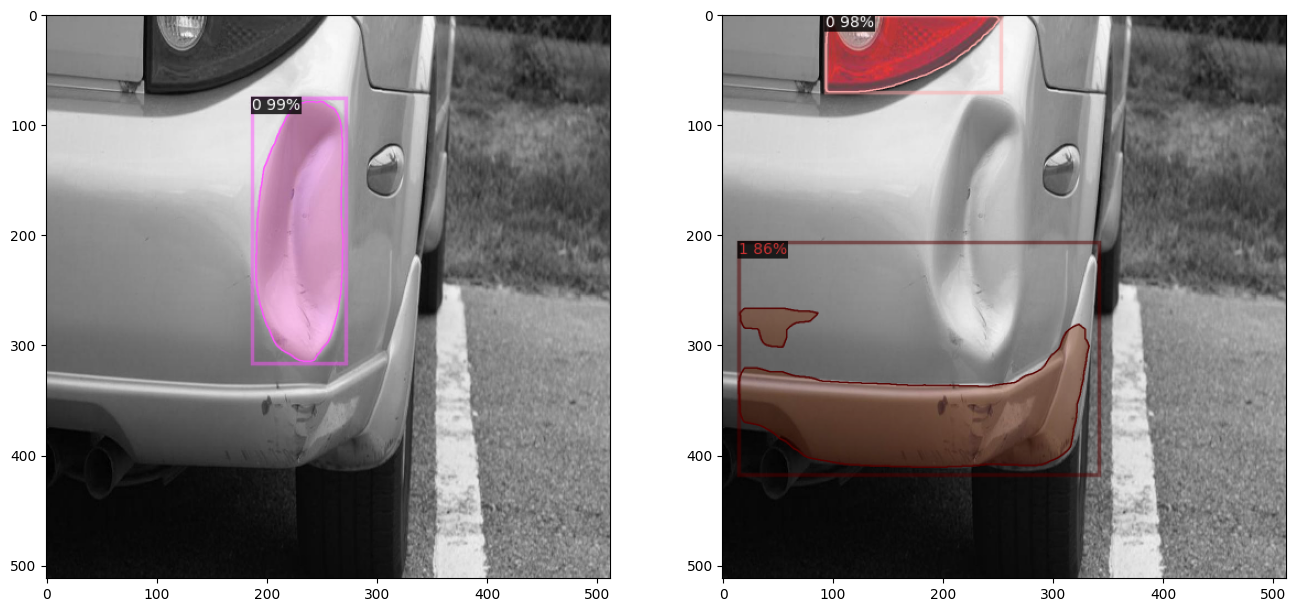

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/drive/MyDrive/car_damage_data/val/1.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [ ]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()



#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

In [ ]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

Damaged Parts:  ['rear_bumper']
